In [6]:
import pandas as pd
attendance_df = pd.read_csv('../processed_data/attendance.csv') 
attendance_df.head()

,year,team_full_name,week,weekly_attendance,home
0,2000,Arizona Cardinals,1,77434.0,False
1,2000,Arizona Cardinals,2,66009.0,True
2,2000,Arizona Cardinals,3,NaN,NaN
3,2000,Arizona Cardinals,4,71801.0,True
4,2000,Arizona Cardinals,5,66985.0,False


In [7]:
attendance_df_home = attendance_df[attendance_df['home'] == True]

In [ ]:
yearly_attendance_average_df = attendance_df_home.groupby(["team_full_name","year"])["weekly_attendance"].mean().reset_index().rename(columns={"weekly_attendance": "yearly_attendance_average"})
yearly_attendance_average_df["lagged_yearly_attendance_average"] = yearly_attendance_average_df.groupby("team_full_name")["yearly_attendance_average"].shift(1).fillna(0) # This fillna we can have 100% efficiency

,team_full_name,year,yearly_attendance_average,lagged_yearly_attendance_average
0,Arizona Cardinals,2000,48434.375,0.000
1,Arizona Cardinals,2001,38414.375,48434.375
2,Arizona Cardinals,2002,40909.000,38414.375
3,Arizona Cardinals,2003,36062.375,40909.000
4,Arizona Cardinals,2004,37533.375,36062.375
...,...,...,...,...
633,Washington Redskins,2015,76209.000,77964.375
634,Washington Redskins,2016,78304.000,76209.000
635,Washington Redskins,2017,75175.625,78304.000
636,Washington Redskins,2018,61028.375,75175.625


In [9]:
# Map the last year average to each row as a new feature
attendance_df_home = attendance_df_home.merge(
    yearly_attendance_average_df[["team_full_name", "year", "lagged_yearly_attendance_average"]],
    on=["team_full_name", "year"],
    how="left"
).rename(columns={"lagged_yearly_attendance_average": "last_year_avg_attendance"})
attendance_df_home.head()

,year,team_full_name,week,weekly_attendance,home,last_year_avg_attendance
0,2000,Arizona Cardinals,2,66009.0,True,0.0
1,2000,Arizona Cardinals,4,71801.0,True,0.0
2,2000,Arizona Cardinals,6,44296.0,True,0.0
3,2000,Arizona Cardinals,7,38293.0,True,0.0
4,2000,Arizona Cardinals,9,35286.0,True,0.0


In [10]:
attendance_df_home = attendance_df_home.loc[attendance_df_home["year"] != 0]

y_true = attendance_df_home["weekly_attendance"].values
y_pred = attendance_df_home["last_year_avg_attendance"].values


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
median_error = np.median(np.abs(y_true - y_pred))
print(f"MAE: {mae}, MSE: {mse}, Median Error: {median_error}")

MAE: 5832.958268025079, MSE: 258063386.19504312, Median Error: 890.0


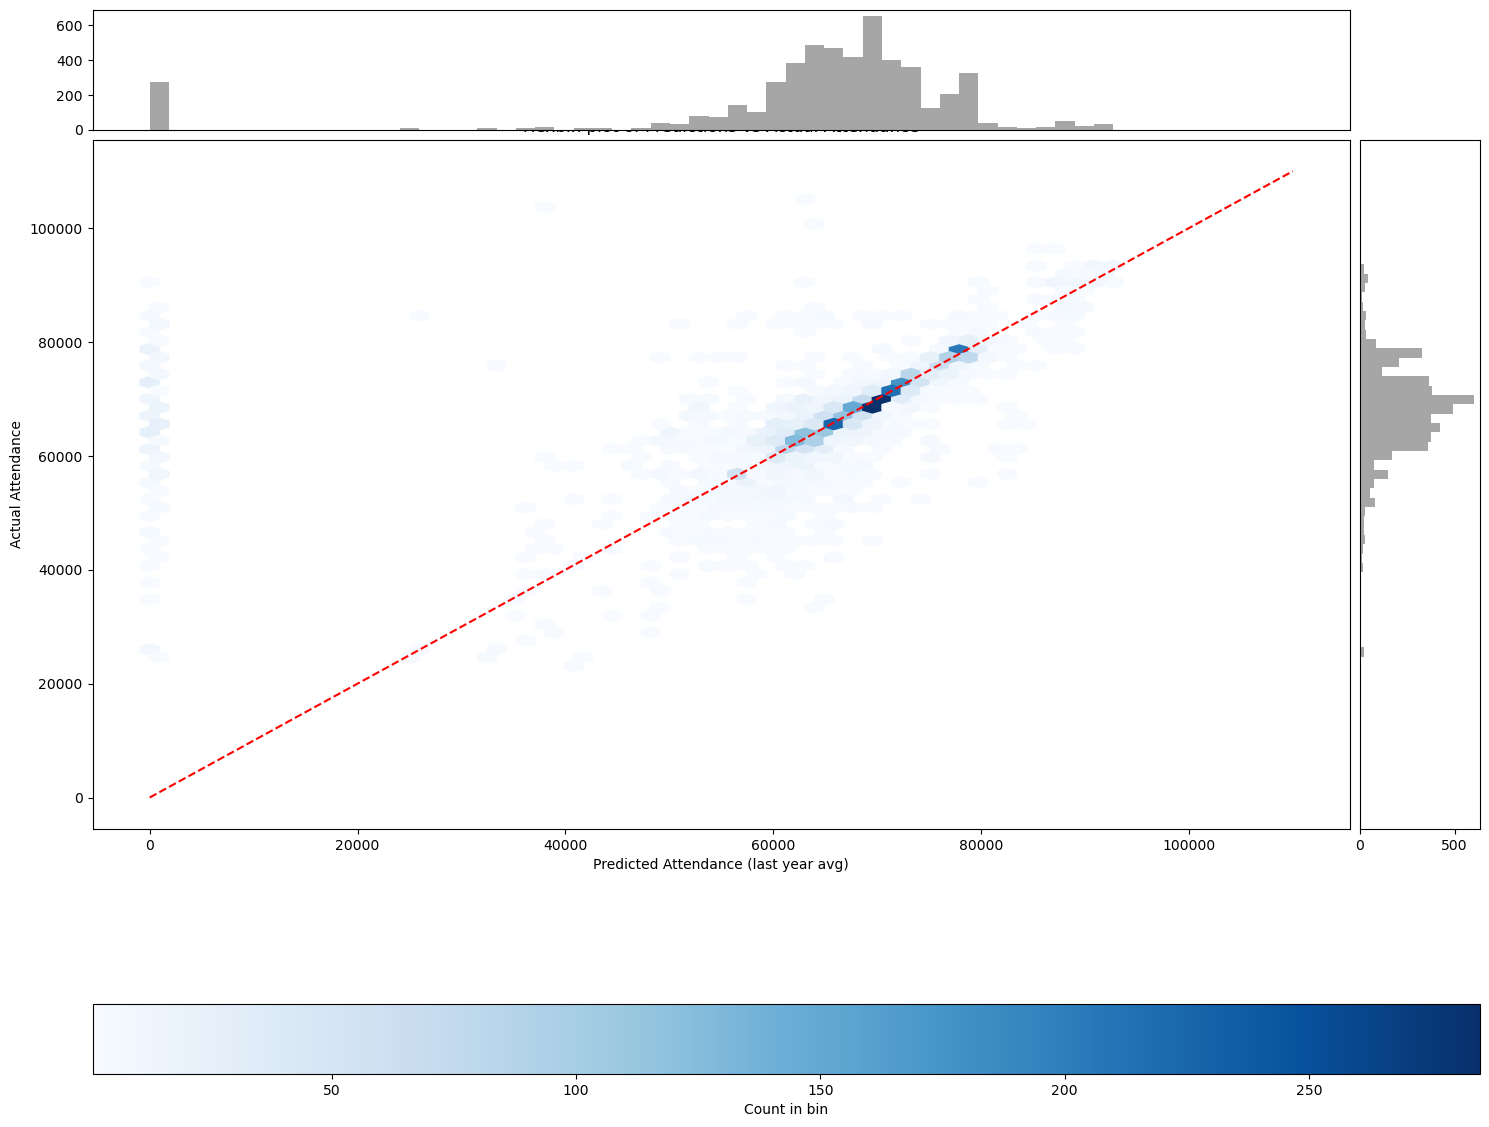

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create a new figure and main axis
fig, ax_main = plt.subplots(figsize=(15, 12))

# Use make_axes_locatable to create marginal axes
divider = make_axes_locatable(ax_main)
ax_histx = divider.append_axes("top", size=1.2, pad=0.1, sharex=ax_main)
ax_histy = divider.append_axes("right", size=1.2, pad=0.1, sharey=ax_main)

# Main hexbin plot
hb = ax_main.hexbin(y_pred, y_true, gridsize=50, cmap='Blues', mincnt=1)

# Add identity/reference line
ax_main.plot([0, 110000], [0, 110000], color='red', linestyle='--', linewidth=1.5, label='Perfect Prediction')

# Marginal histograms
ax_histx.hist(y_pred, bins=50, color='gray', alpha=0.7)
ax_histy.hist(y_true, bins=50, orientation='horizontal', color='gray', alpha=0.7)

# Clean up ticks on marginals
ax_histx.tick_params(axis="x", labelbottom=False, bottom=False)
ax_histy.tick_params(axis="y", labelleft=False, left=False)

# Labels and title on main axis
ax_main.set_xlabel('Predicted Attendance (last year avg)')
ax_main.set_ylabel('Actual Attendance')
ax_main.set_title('Hexbin plot of Predictions vs Actual Attendance')

# Colorbar
cb = fig.colorbar(hb, ax=ax_main, orientation='horizontal', pad=0.15)
cb.set_label('Count in bin')

plt.tight_layout()
plt.show()
